## README

Notebook criado para resolver o problema 1 do desafio de cientista de dados, da Neurotech.

## SETUP

In [1]:
# Bibliotecas de uso geral
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tratamento dos dados
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Bibliotecas utilizadas para as etapas iniciais de Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Bibliotecas de modelagem
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Bibliotecas utilizadas para a avaliação dos modelos
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# Avaliação de propriedades estatísticas
import statsmodels.api as sm
from scipy.stats import ks_2samp

# Configurações do pandas e do python
pd.set_option('display.max_rows', 50)
import warnings
warnings.filterwarnings("ignore")


## FUNÇÕES E CONSTANTES

In [2]:
# Definição de variável para reproducibilidade
seed = 101

In [3]:
def plot_categorical_distribution(df, var):
    # Cria os plots das variáveis categóricas
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var, palette='Set2')
    plt.title(f'Distribuição da variável: {var}')
    plt.xlabel(var)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_numerical_distribution(df, var, bins=20):
    # Cria os plots das variáveis numéricas
    plt.figure(figsize=(8, 6))
    sns.histplot(df, x=var, hue='TARGET', bins=bins, kde=True, palette='Set1', edgecolor='black')
    plt.title(f'Distribuição da variável: {var} pelo TARGET')
    plt.xlabel(var)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

## INGESTÃO DE DADOS

In [5]:
df_train = pd.read_csv('train.gz')
df_train.shape

(120750, 151)

In [6]:
df_test = pd.read_csv('test.gz')
df_test.shape

(51751, 151)

In [7]:
df_oot = pd.read_csv('oot.gz')
df_oot.shape

(91965, 150)

## EDA E FEATURE ENGINEERING

### ANÁLISES MACRO

In [8]:
df_train.dtypes

REF_DATE     object
TARGET        int64
VAR2         object
IDADE       float64
VAR4         object
             ...   
VAR146      float64
VAR147        int64
VAR148       object
VAR149       object
ID            int64
Length: 151, dtype: object

In [9]:
df_train.head(2)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.87847,D,E,...,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.92608,E,E,...,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633


In [10]:
# Divisão das variáveis entre numéricas e categóricas
vars_discretas = df_train.select_dtypes(include=['int']).columns.tolist()
vars_continuas = df_train.select_dtypes(include=['float']).columns.tolist()
vars_categoricas = df_train.select_dtypes(exclude=['float', 'int']).columns.tolist()
vars_numericas = df_train.select_dtypes(include='number').columns.tolist()

# Remoção dos campos que não entrarão no loop de EDA
vars_categoricas.remove('REF_DATE')
vars_discretas.remove('TARGET')
vars_discretas.remove('ID')
vars_numericas.remove('TARGET')
vars_numericas.remove('ID')

In [11]:
# Valores mínimos e máximos da referência
print(f"Referência mais antiga: {df_train['REF_DATE'].min()}")
print(f"Referência mais recente: {df_train['REF_DATE'].max()}")

Referência mais antiga: 2017-01-02 00:00:00+00:00
Referência mais recente: 2017-08-31 00:00:00+00:00


In [12]:
# Mostrando a amplitude das variáveis numéricas
df_train[vars_numericas].describe()

,IDADE,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,...,VAR40,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147
count,107040.000000,117394.000000,117394.000000,74488.000000,65724.000000,15530.000000,95197.000000,58269.000000,44981.000000,15530.000000,...,117466.000000,117811.000000,107048.000000,401.000000,294.000000,120750.000000,120750.000000,679.000000,168.000000,120750.000000
mean,42.125255,-14.411389,-45.903480,0.235917,0.290241,0.313850,0.241245,0.185754,2.044374,2.132795,...,0.531287,0.631175,0.504619,1691.738429,6984.218469,0.256543,1854.833006,4018.743785,1942.649762,101.841656
std,15.198476,8.995077,7.529788,0.625609,0.308937,0.241229,0.262687,0.195320,3.170869,2.171140,...,0.115968,0.222607,0.069614,2177.830516,4621.964093,0.406746,893.999792,3700.836248,3143.757850,0.540016
min,18.014000,-33.521563,-72.900276,-4.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.002740,...,0.208688,0.000000,0.006658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000
25%,30.057250,-22.842778,-49.903564,0.000000,0.055000,0.056000,0.105000,0.078000,0.250000,0.493151,...,0.447559,0.440572,0.463579,642.000000,3888.995000,0.000000,1513.227400,1633.195000,0.000000,102.000000
50%,39.867000,-13.010590,-46.574908,0.000000,0.159000,0.318000,0.140000,0.112000,0.833333,0.816438,...,0.510023,0.542298,0.496036,769.000000,5386.310000,0.003000,1627.157652,3024.480000,935.120000,102.000000
75%,52.997000,-6.357067,-39.023621,0.000000,0.505000,0.507000,0.168000,0.153000,2.416667,4.079452,...,0.582701,0.898052,0.522576,1747.500000,9601.390000,0.421000,1820.670284,5217.670000,2260.125000,102.000000
max,105.477000,4.602823,-32.429516,4.000000,1.500000,1.000000,1.700000,1.000000,15.999999,8.999999,...,0.920685,1.000000,0.910865,17374.940000,26523.920000,1.000000,33954.140000,33954.140000,17229.200000,102.000000


### VARIÁVEIS ID E TARGET

Conclusões: 
1. Cada cliente é único, não há IDs repetidos
2. Os dados estão desbalanceados em termos de target
3. A taxa de concessão parece ser constante (aproximadamente 4 em cada 5 clientes), mas algo parece ter acontecido em março de 2017, quando o número de IDs atingiu um pico localizado e a taxa de concessão caiu de 80% para 50% (valores aproximados).

In [13]:
# Não existem valores repetidos de ID
df_train['ID'].nunique()

120750

In [14]:
# Variável target
print(f'Distribuição da variável target:')
df_train['TARGET'].value_counts(normalize=True)

Distribuição da variável target:


TARGET
0    0.754973
1    0.245027
Name: proportion, dtype: float64

ref_date_trunc
2017-01-01    3441
2017-02-01    3087
2017-03-01    7950
2017-04-01    2795
2017-05-01    2971
2017-06-01    2964
2017-07-01    3084
2017-08-01    3295
Name: TARGET, dtype: int64

<Axes: xlabel='ref_date_trunc'>

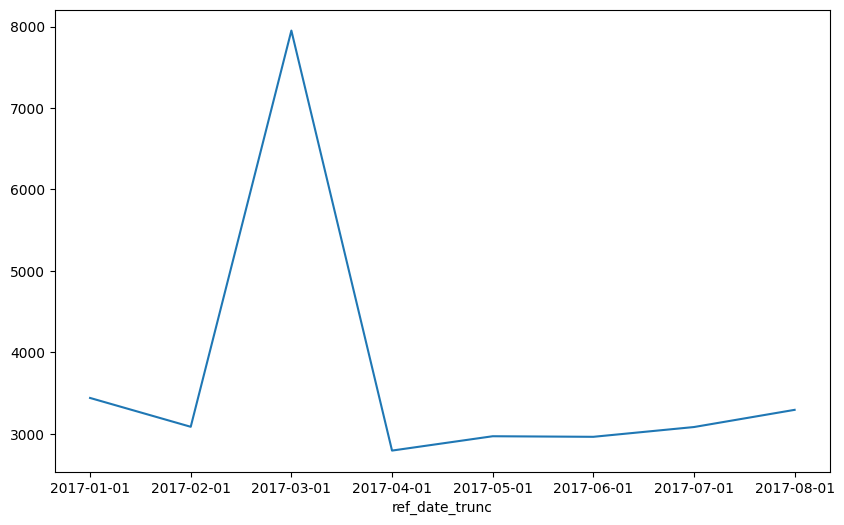

In [15]:
# Distribuição da variável target ao longo do tempo
df_train['ref_date_trunc'] = pd.to_datetime(df_train['REF_DATE']).dt.strftime('%Y-%m-01')
df_test['ref_date_trunc'] = pd.to_datetime(df_test['REF_DATE']).dt.strftime('%Y-%m-01')

display(df_train[df_train['TARGET'] == 1].groupby('ref_date_trunc')['TARGET'].count())

target_counts = df_train[df_train['TARGET'] == 1].groupby('ref_date_trunc')['TARGET'].count()
plt.figure(figsize=(10, 6))
sns.lineplot(x=target_counts.index, y=target_counts.values)

In [16]:
# Distribuição da variável target ao longo do tempo
display(df_train.groupby('ref_date_trunc')['TARGET'].mean())

ref_date_trunc
2017-01-01    0.236706
2017-02-01    0.225378
2017-03-01    0.495451
2017-04-01    0.207037
2017-05-01    0.208931
2017-06-01    0.196852
2017-07-01    0.187534
2017-08-01    0.191037
Name: TARGET, dtype: float64

ref_date_trunc
2017-01-01    14537
2017-02-01    13697
2017-03-01    16046
2017-04-01    13500
2017-05-01    14220
2017-06-01    15057
2017-07-01    16445
2017-08-01    17248
Name: ID, dtype: int64

<Axes: xlabel='ref_date_trunc'>

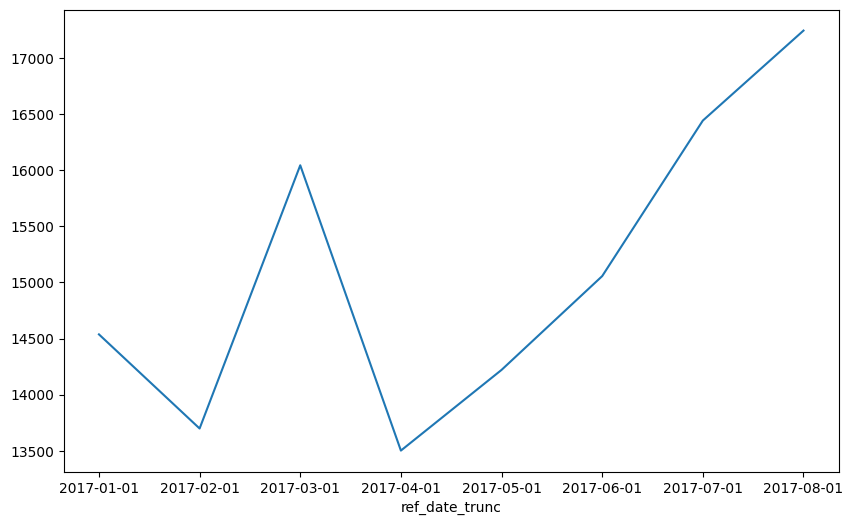

In [17]:
# Distribuição da variável ID ao longo do tempo
display(df_train.groupby('ref_date_trunc')['ID'].count())

target_counts = df_train.groupby('ref_date_trunc')['ID'].count()

plt.figure(figsize=(10, 6))  # Optional: set the size of the plot
sns.lineplot(x=target_counts.index, y=target_counts.values)

### PLOT DE VARIÁVEIS

Como as variáveis estão mascaradas e não há muita interpretação, os códigos abaixo apenas ilustram o tipo de análise por gráfico que pode ser feito.

#### VARIÁVEIS CATEGÓRICAS

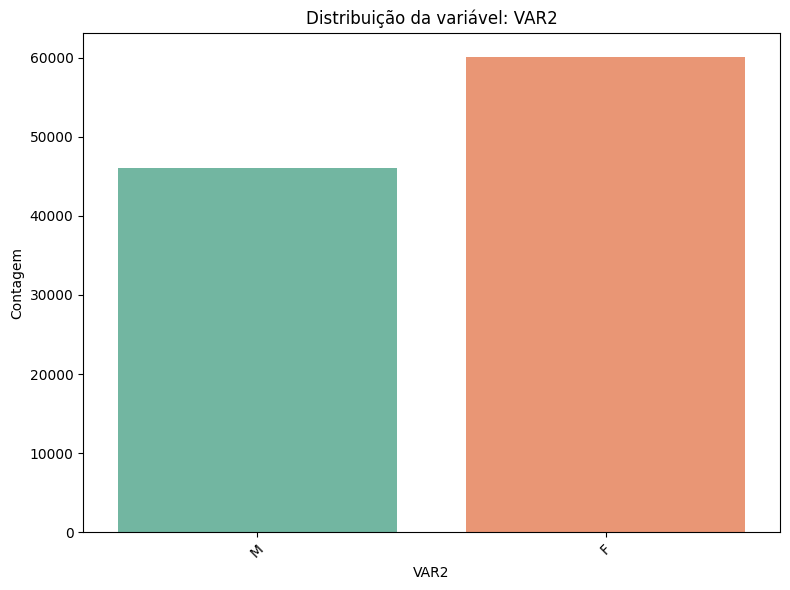

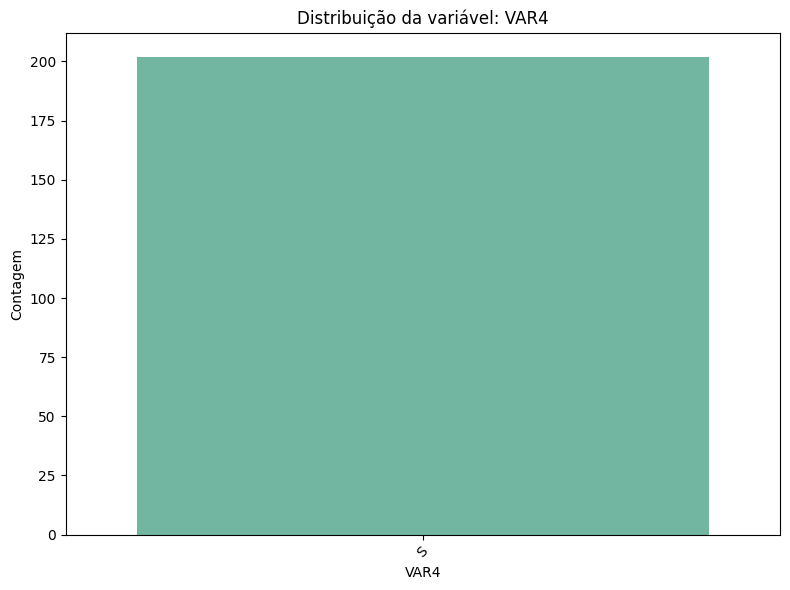

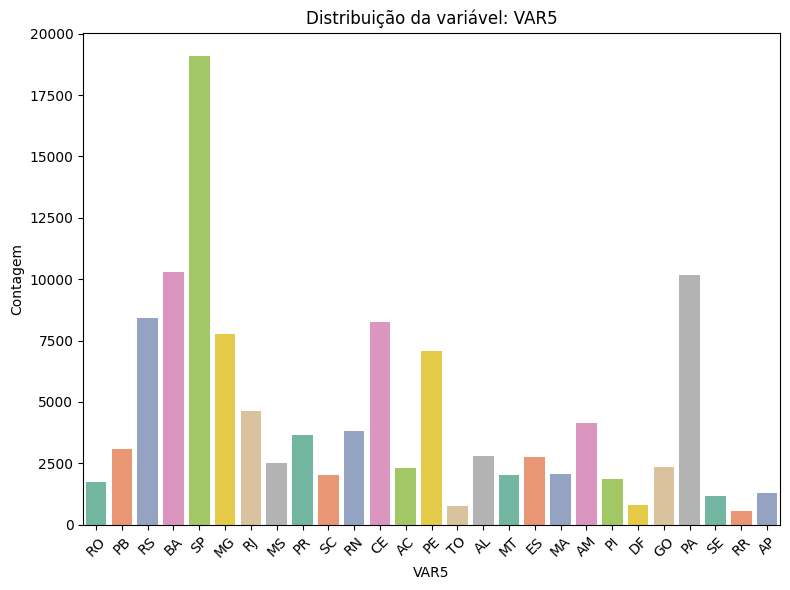

In [18]:
# Loop para gerar o gráfico de cada variável
for var in vars_categoricas[:3]:
    plot_categorical_distribution(df_train, var)

#### VARIÁVEIS NUMÉRICAS

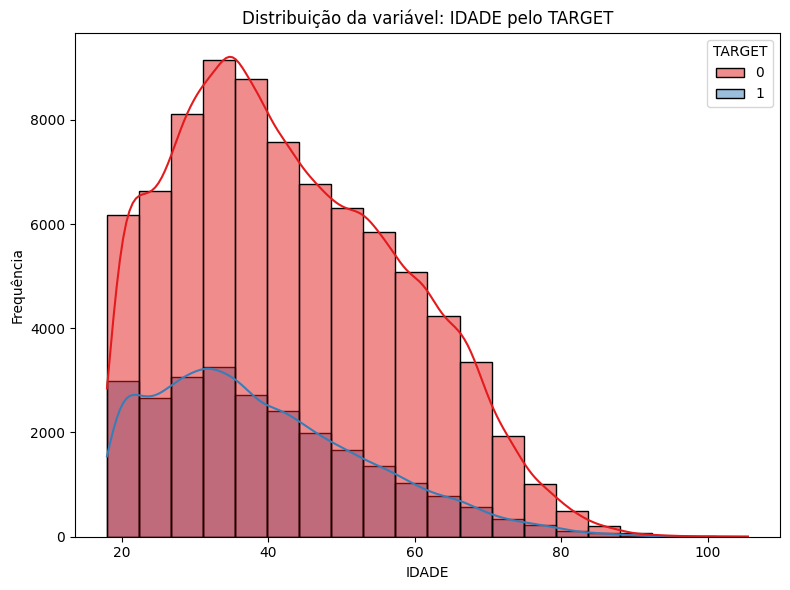

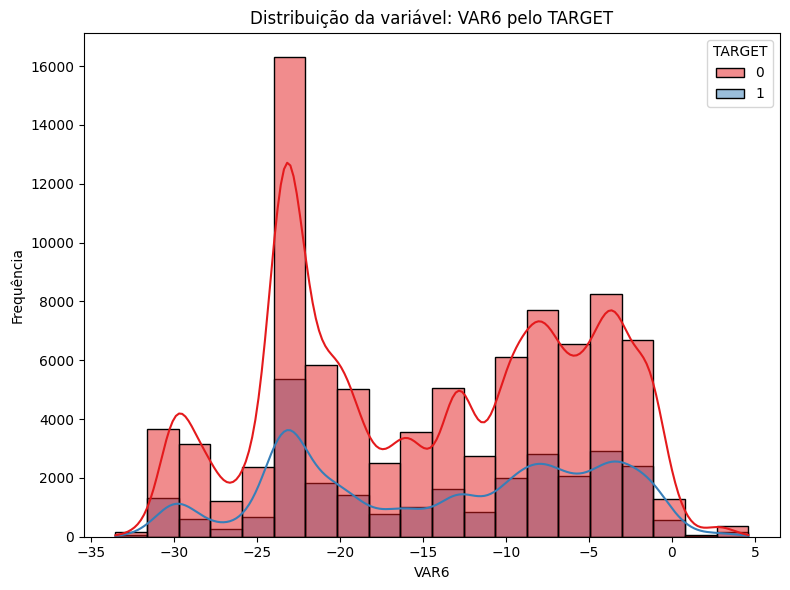

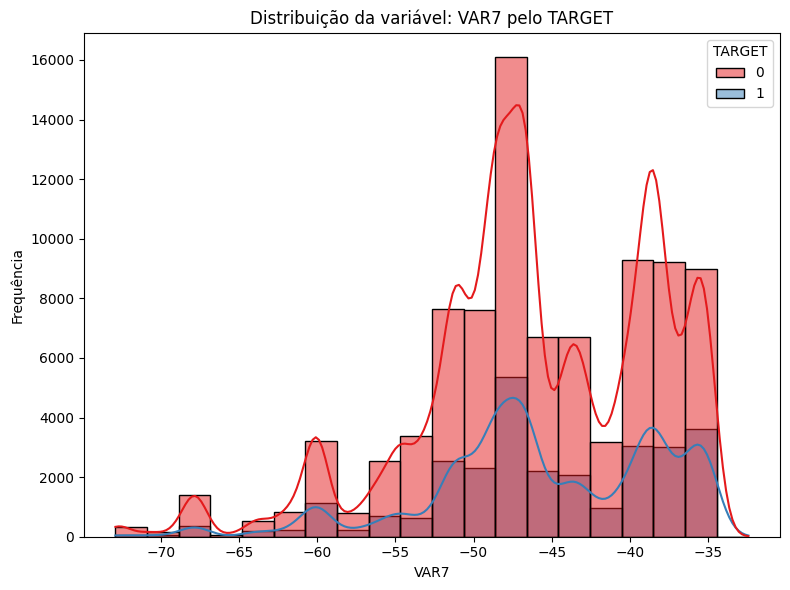

In [19]:
# Loop para gerar o gráfico de cada variável
for var in vars_numericas[:3]:
    plot_numerical_distribution(df_train, var)

### NULOS, NEGATIVOS E INFINITO

Conclusões:
1. Não é possível saber se os valores negativos estão incorretos, visto que os nomes dos campos estão mascarados
2. Não há valores mais ou menos infinito
3. Aparentemente, boa parte dos campos tem valores nulos. Com exceção do campo IDADE, todos os demais campos estão mascarados. Assim, os campos numéricos serão preenchidos com a mediana e os campos categóricos com a moda

In [20]:
# Lista de variáveis com valores negativos
lst_vars_with_negative = list()

# Loop que checa as colunas com valores negativos
for column in df_train.columns:
    if(df_train[column].dtype != 'object'):
        if((df_train[column] < 0).sum() > 0): 
            print(f"Valores negativos em {column}: {(df_train[column] < 0).sum()}")
            lst_vars_with_negative.append(column)

Valores negativos em VAR6: 115892
Valores negativos em VAR7: 117394
Valores negativos em VAR11: 583


In [21]:
# Lista de variáveis com valores infinitos
lst_vars_with_inf = list()

# Loop que checa as colunas com valores nulos
for column in df_train.columns:
    if(df_train[column].dtype != 'object'):
        if((np.isneginf(df_train[column]).sum() > 0) | (np.isposinf(df_train[column]).sum() > 0)): 
            print(f"Valores infiinitos em {column}: {np.isneginf(df_train[column]).sum() + np.isposinf(df_train[column]).sum()}")
            lst_vars_with_inf.append(column)

In [22]:
# Lista de variáveis com valores nulos
lst_vars_with_null = list()

# Loop que checa as colunas com valores nulos
for column in df_train.columns:
    if(df_train[column].isnull().sum() > 0): 
        print(f"Nulos em {column}: {df_train[column].isnull().sum()}")
        lst_vars_with_null.append(column)

Nulos em VAR2: 14619
Nulos em IDADE: 13710
Nulos em VAR4: 120548
Nulos em VAR5: 3356
Nulos em VAR6: 3356
Nulos em VAR7: 3356
Nulos em VAR8: 53110
Nulos em VAR9: 3303
Nulos em VAR10: 3276
Nulos em VAR11: 46262
Nulos em VAR12: 55026
Nulos em VAR13: 105220
Nulos em VAR14: 25553
Nulos em VAR15: 62481
Nulos em VAR16: 75769
Nulos em VAR17: 105220
Nulos em VAR18: 25553
Nulos em VAR19: 62481
Nulos em VAR20: 109397
Nulos em VAR21: 105157
Nulos em VAR22: 62421
Nulos em VAR23: 105220
Nulos em VAR24: 23465
Nulos em VAR25: 62481
Nulos em VAR26: 119742
Nulos em VAR27: 119708
Nulos em VAR28: 108031
Nulos em VAR29: 96026
Nulos em VAR30: 108031
Nulos em VAR31: 116833
Nulos em VAR32: 78698
Nulos em VAR33: 112129
Nulos em VAR34: 112129
Nulos em VAR35: 94654
Nulos em VAR36: 95706
Nulos em VAR37: 95706
Nulos em VAR38: 119981
Nulos em VAR39: 71
Nulos em VAR40: 3284
Nulos em VAR41: 2939
Nulos em VAR42: 13702
Nulos em VAR43: 120349
Nulos em VAR44: 120349
Nulos em VAR45: 120456
Nulos em VAR46: 120456
Nulos em 

In [23]:
# Cálculo das modas e medianas para preencher os valores nulos
mode_values = df_train[vars_categoricas].mode().iloc[0]
median_values = df_train[vars_numericas].median()

# Preenchimento de valores nulos
df_train[vars_categoricas] = df_train[vars_categoricas].fillna(mode_values)
df_train[vars_numericas] = df_train[vars_numericas].fillna(median_values)
df_test[vars_categoricas] = df_test[vars_categoricas].fillna(mode_values)
df_test[vars_numericas] = df_test[vars_numericas].fillna(median_values)

### VARIÁVEIS CATEGÓRICAS

Conclusão:
1. Remover as VAR148, cujo conteúdo não é interessante para modelagem
2. Algumas variáveis tem apenas um valor - essas serão removidas nos métodos de feature selection
3. As variáveis onde existe uma noção clara de escalonamento, como a VAR10, receberão label encoding. 
4. As variáveis sim e não, serão substituídas por 1 e 0. 
5. As variáveis que são preenchidas de outras formas receberão one hot encoding.

In [24]:
# Checagem das variáveis categóricas e seus valores
for column in df_train[vars_categoricas].columns:
    display(df_train[column].value_counts())

VAR2
F    74750
M    46000
Name: count, dtype: int64

VAR4
S    120750
Name: count, dtype: int64

VAR5
SP    22435
BA    10306
PA    10159
RS     8410
CE     8262
MG     7757
PE     7056
RJ     4617
AM     4145
RN     3800
PR     3668
PB     3085
AL     2800
ES     2765
MS     2515
GO     2369
AC     2304
MA     2083
MT     2015
SC     2013
PI     1858
RO     1731
AP     1292
SE     1175
DF      790
TO      767
RR      573
Name: count, dtype: int64

VAR8
E    108038
D      9130
C      2972
B       449
A       161
Name: count, dtype: int64

VAR9
E    119433
C       726
D       537
B        47
A         7
Name: count, dtype: int64

VAR10
MEDIA         43533
ALTISSIMA     37260
ALTA          20842
BAIXA         13577
BAIXISSIMA     5538
Name: count, dtype: int64

VAR31
BANCO DO BRASIL                         118270
CAIXA ECONOMICA FEDERAL                    779
BANCO BRADESCO                             776
BANCO ITAU                                 471
BANCO SANTANDER                            265
BANCO DO ESTADO DO RIO GRANDE DO SUL       137
HSBC BANK BRASIL                            52
Name: count, dtype: int64

VAR32
DECLARACAO NAO ENVIADA         113671
CREDITADA                        3667
SALDO INEXISTENTE                1669
IMPOSTO A PAGAR                  1229
DECLARACAO ENVIADA                415
DEVOLVIDA A RECEITA FEDERAL        61
AGUARDANDO REAGENDAMENTO           38
Name: count, dtype: int64

VAR33
S    120750
Name: count, dtype: int64

VAR34
PMDB       113171
PT            832
PSDB          800
PDT           691
PP            639
PTB           594
DEM           526
PR            408
PSB           351
PRB           326
PC DO B       251
PPS           230
PSC           227
PV            211
PMN           147
PSD           145
PSL           132
PSDC          123
PHS           113
PRP           112
PSOL          112
PT DO B       108
PTC           100
PTN            91
SD             82
PRTB           67
PROS           52
PEN            46
PPL            30
PCB            15
PSTU            8
REDE            7
PCO             2
NOVO            1
Name: count, dtype: int64

VAR35
S    120750
Name: count, dtype: int64

VAR36
S    120750
Name: count, dtype: int64

VAR38
S    120750
Name: count, dtype: int64

VAR43
S    120750
Name: count, dtype: int64

VAR45
S    120750
Name: count, dtype: int64

VAR48
N    116933
S      3817
Name: count, dtype: int64

VAR49
S    112868
N      7882
Name: count, dtype: int64

VAR50
N    91021
S    29729
Name: count, dtype: int64

VAR51
N    117458
S      3292
Name: count, dtype: int64

VAR52
N    112702
S      8048
Name: count, dtype: int64

VAR53
N    118547
S      2203
Name: count, dtype: int64

VAR54
N    117435
S      3315
Name: count, dtype: int64

VAR55
N    114087
S      6663
Name: count, dtype: int64

VAR56
N    103216
S     17534
Name: count, dtype: int64

VAR57
N    118897
S      1853
Name: count, dtype: int64

VAR58
N    119504
S      1246
Name: count, dtype: int64

VAR59
N    116786
S      3964
Name: count, dtype: int64

VAR60
N    114361
S      6389
Name: count, dtype: int64

VAR61
N    106622
S     14128
Name: count, dtype: int64

VAR62
N    117113
S      3637
Name: count, dtype: int64

VAR63
N    109949
S     10801
Name: count, dtype: int64

VAR64
N    114196
S      6554
Name: count, dtype: int64

VAR65
N    102397
S     18353
Name: count, dtype: int64

VAR66
MEDIA         37809
BAIXISSIMA    32366
ALTA          27288
ALTISSIMA     23287
Name: count, dtype: int64

VAR67
BAIXISSIMA    77875
ALTISSIMA     25899
ALTA          16976
Name: count, dtype: int64

VAR68
BAIXISSIMA    50768
ALTA          29591
MEDIA         21427
ALTISSIMA     18964
Name: count, dtype: int64

VAR69
BAIXISSIMA    68153
ALTA          29546
ALTISSIMA     14415
MEDIA          8636
Name: count, dtype: int64

VAR70
MEDIA         41826
BAIXISSIMA    29369
ALTA          27906
ALTISSIMA     21649
Name: count, dtype: int64

VAR71
MEDIA         34129
ALTA          29947
ALTISSIMA     26824
BAIXISSIMA    23980
BAIXA          5870
Name: count, dtype: int64

VAR72
BAIXISSIMA    55760
ALTA          30482
MEDIA         18258
ALTISSIMA     16250
Name: count, dtype: int64

VAR73
BAIXISSIMA    54600
ALTA          30410
ALTISSIMA     18624
MEDIA         17116
Name: count, dtype: int64

VAR74
MEDIA         36246
BAIXISSIMA    32654
ALTA          26409
ALTISSIMA     25441
Name: count, dtype: int64

VAR75
BAIXISSIMA    37848
MEDIA         33412
ALTA          25364
ALTISSIMA     24126
Name: count, dtype: int64

VAR76
ALTA          42888
BAIXISSIMA    38211
ALTISSIMA     22257
MEDIA         17394
Name: count, dtype: int64

VAR77
BAIXISSIMA    57235
ALTA          27569
ALTISSIMA     18821
MEDIA         17125
Name: count, dtype: int64

VAR78
BAIXISSIMA    40168
MEDIA         33584
ALTA          24975
ALTISSIMA     22023
Name: count, dtype: int64

VAR79
BAIXISSIMA    53246
ALTA          33755
ALTISSIMA     18676
MEDIA         15073
Name: count, dtype: int64

VAR80
BAIXISSIMA    59898
ALTA          26700
ALTISSIMA     19102
MEDIA         15050
Name: count, dtype: int64

VAR81
ALTISSIMA     36953
MEDIA         26580
ALTA          24571
BAIXA         17175
BAIXISSIMA    15471
Name: count, dtype: int64

VAR82
BAIXISSIMA    65499
ALTA          29722
ALTISSIMA     25529
Name: count, dtype: int64

VAR83
BAIXISSIMA    51743
ALTA          25963
MEDIA         25662
ALTISSIMA     17382
Name: count, dtype: int64

VAR84
BAIXISSIMA    65810
ALTA          28177
ALTISSIMA     25609
MEDIA          1154
Name: count, dtype: int64

VAR85
BAIXISSIMA    44325
ALTA          30812
MEDIA         23267
ALTISSIMA     22346
Name: count, dtype: int64

VAR86
BAIXISSIMA    37426
MEDIA         31083
ALTA          27750
ALTISSIMA     24491
Name: count, dtype: int64

VAR87
MEDIA         35053
ALTA          28290
ALTISSIMA     26086
BAIXISSIMA    24289
BAIXA          7032
Name: count, dtype: int64

VAR88
ALTISSIMA     35604
MEDIA         28230
ALTA          24599
BAIXISSIMA    21921
BAIXA         10396
Name: count, dtype: int64

VAR89
BAIXISSIMA    42291
ALTA          30849
MEDIA         30666
ALTISSIMA     16944
Name: count, dtype: int64

VAR90
BAIXISSIMA    106186
ALTISSIMA      14564
Name: count, dtype: int64

VAR91
ALTISSIMA     32846
MEDIA         28909
BAIXISSIMA    25997
ALTA          25093
BAIXA          7905
Name: count, dtype: int64

VAR92
MEDIA         38791
BAIXISSIMA    32408
ALTISSIMA     25014
ALTA          24537
Name: count, dtype: int64

VAR93
BAIXISSIMA    74062
ALTISSIMA     25619
ALTA          21069
Name: count, dtype: int64

VAR94
BAIXISSIMA    46254
ALTA          31279
ALTISSIMA     23039
MEDIA         20178
Name: count, dtype: int64

VAR95
BAIXISSIMA    63289
ALTA          39679
ALTISSIMA     17782
Name: count, dtype: int64

VAR96
ALTA          31969
MEDIA         28947
ALTISSIMA     26196
BAIXISSIMA    24034
BAIXA          9604
Name: count, dtype: int64

VAR97
MEDIA         41475
BAIXISSIMA    30749
ALTA          27246
ALTISSIMA     21280
Name: count, dtype: int64

VAR98
BAIXISSIMA    41309
MEDIA         31222
ALTA          26286
ALTISSIMA     21933
Name: count, dtype: int64

VAR99
ALTISSIMA     34151
ALTA          27331
MEDIA         26316
BAIXISSIMA    23616
BAIXA          9336
Name: count, dtype: int64

VAR100
BAIXISSIMA    101340
ALTISSIMA      19410
Name: count, dtype: int64

VAR101
BAIXISSIMA    44655
MEDIA         27963
ALTA          27687
ALTISSIMA     20445
Name: count, dtype: int64

VAR102
LONGE            40346
MUITO LONGE      32923
MEDIO            23967
PROXIMO          22345
MUITO PROXIMO     1169
Name: count, dtype: int64

VAR103
MUITO LONGE      37359
LONGE            31591
MEDIO            27052
PROXIMO          20470
MUITO PROXIMO     4278
Name: count, dtype: int64

VAR104
MUITO LONGE      37668
LONGE            33534
MEDIO            25068
PROXIMO          21955
MUITO PROXIMO     2525
Name: count, dtype: int64

VAR105
MUITO LONGE      43056
LONGE            35069
MEDIO            30095
PROXIMO           9328
MUITO PROXIMO     3202
Name: count, dtype: int64

VAR106
MUITO LONGE      37402
LONGE            31475
MEDIO            27237
PROXIMO          23240
MUITO PROXIMO     1396
Name: count, dtype: int64

VAR107
LONGE            37906
MUITO LONGE      33681
MEDIO            29120
PROXIMO          19910
MUITO PROXIMO      133
Name: count, dtype: int64

VAR108
MEDIO            36798
MUITO LONGE      32933
LONGE            26054
PROXIMO          22703
MUITO PROXIMO     2262
Name: count, dtype: int64

VAR109
LONGE            42766
MUITO LONGE      34815
MEDIO            32165
PROXIMO           9099
MUITO PROXIMO     1905
Name: count, dtype: int64

VAR110
MUITO LONGE      37998
LONGE            34575
MEDIO            25222
PROXIMO          22426
MUITO PROXIMO      529
Name: count, dtype: int64

VAR111
MUITO LONGE      37052
MEDIO            31590
LONGE            29511
PROXIMO          20598
MUITO PROXIMO     1999
Name: count, dtype: int64

VAR112
MUITO LONGE      36875
LONGE            30324
MEDIO            29396
PROXIMO          23286
MUITO PROXIMO      869
Name: count, dtype: int64

VAR113
MUITO LONGE      37346
LONGE            30195
PROXIMO          27344
MEDIO            25756
MUITO PROXIMO      109
Name: count, dtype: int64

VAR114
MUITO LONGE      37722
LONGE            34375
MEDIO            27933
PROXIMO          20532
MUITO PROXIMO      188
Name: count, dtype: int64

VAR115
LONGE            37600
MUITO LONGE      32487
MEDIO            32224
PROXIMO          16714
MUITO PROXIMO     1725
Name: count, dtype: int64

VAR116
MUITO LONGE      35450
MEDIO            31117
LONGE            24874
PROXIMO          16619
MUITO PROXIMO    12690
Name: count, dtype: int64

VAR117
MUITO LONGE      40428
LONGE            33181
PROXIMO          23987
MEDIO            20376
MUITO PROXIMO     2778
Name: count, dtype: int64

VAR118
MUITO LONGE      35326
LONGE            32351
MEDIO            25596
MUITO PROXIMO    14651
PROXIMO          12826
Name: count, dtype: int64

VAR119
MUITO LONGE      34635
LONGE            29967
MEDIO            29748
PROXIMO          26373
MUITO PROXIMO       27
Name: count, dtype: int64

VAR120
MUITO LONGE    105177
PROXIMO         15573
Name: count, dtype: int64

VAR121
MUITO LONGE    35628
MEDIO          31134
LONGE          27087
PROXIMO        26901
Name: count, dtype: int64

VAR122
MUITO LONGE      36835
LONGE            31957
MEDIO            26533
PROXIMO          24755
MUITO PROXIMO      670
Name: count, dtype: int64

VAR123
MUITO LONGE      38272
MEDIO            33099
LONGE            25473
PROXIMO          21115
MUITO PROXIMO     2791
Name: count, dtype: int64

VAR124
MUITO LONGE      34959
LONGE            29931
MEDIO            29866
PROXIMO          21342
MUITO PROXIMO     4652
Name: count, dtype: int64

VAR125
MUITO LONGE      37466
MEDIO            31507
PROXIMO          24845
LONGE            24304
MUITO PROXIMO     2628
Name: count, dtype: int64

VAR126
MEDIO            38025
LONGE            34042
MUITO LONGE      33420
PROXIMO          14446
MUITO PROXIMO      817
Name: count, dtype: int64

VAR127
MUITO LONGE      41950
LONGE            30749
MEDIO            28409
PROXIMO          19535
MUITO PROXIMO      107
Name: count, dtype: int64

VAR128
MUITO LONGE      38057
MEDIO            29096
LONGE            27399
PROXIMO          20715
MUITO PROXIMO     5483
Name: count, dtype: int64

VAR129
MUITO LONGE      37893
LONGE            31658
MEDIO            28969
PROXIMO          21660
MUITO PROXIMO      570
Name: count, dtype: int64

VAR130
MUITO LONGE      37546
LONGE            33591
MEDIO            27857
PROXIMO          21655
MUITO PROXIMO      101
Name: count, dtype: int64

VAR131
LONGE            36895
MEDIO            32281
MUITO LONGE      28442
PROXIMO          20779
MUITO PROXIMO     2353
Name: count, dtype: int64

VAR132
MUITO LONGE      36128
LONGE            28189
MEDIO            28140
PROXIMO          23089
MUITO PROXIMO     5204
Name: count, dtype: int64

VAR133
MUITO LONGE      37861
LONGE            32708
MEDIO            28096
PROXIMO          19114
MUITO PROXIMO     2971
Name: count, dtype: int64

VAR134
MUITO LONGE      35692
LONGE            32193
MEDIO            28142
PROXIMO          23646
MUITO PROXIMO     1077
Name: count, dtype: int64

VAR135
MUITO LONGE      36641
MEDIO            30992
LONGE            25006
PROXIMO          22864
MUITO PROXIMO     5247
Name: count, dtype: int64

VAR136
MUITO LONGE      43895
LONGE            32081
MEDIO            25467
PROXIMO          19218
MUITO PROXIMO       89
Name: count, dtype: int64

VAR137
MUITO LONGE      39245
LONGE            36261
MEDIO            31761
PROXIMO          12445
MUITO PROXIMO     1038
Name: count, dtype: int64

VAR138
MUITO LONGE      38334
LONGE            35280
MEDIO            29585
PROXIMO          17086
MUITO PROXIMO      465
Name: count, dtype: int64

VAR139
LONGE            38458
MUITO LONGE      31978
MEDIO            28485
PROXIMO          21104
MUITO PROXIMO      725
Name: count, dtype: int64

VAR140
MUITO LONGE      55345
MUITO PROXIMO    25652
MEDIO            19219
LONGE            17006
PROXIMO           3528
Name: count, dtype: int64

VAR142
E    94223
D    23072
C     3221
B      204
A       30
Name: count, dtype: int64

VAR143
N    120071
S       679
Name: count, dtype: int64

VAR144
N    120582
S       168
Name: count, dtype: int64

VAR148
EMAIL INEXISTENTE                                         52379
EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INEXISTENTE    50779
OPERACAO REALIZADA COM SUCESSO                             9560
NOME INEXISTENTE#@#EMAIL INEXISTENTE                       7130
CEP INEXISTENTE#@#EMAIL INEXISTENTE                         480
NOME INEXISTENTE                                            413
CEP INEXISTENTE                                               6
NOME INEXISTENTE#@#CEP INEXISTENTE                            3
Name: count, dtype: int64

VAR149
2.6.1    120750
Name: count, dtype: int64

In [25]:
# Remoção de coluna descenessária
df_train.drop(columns='VAR148', inplace=True)
vars_categoricas.remove('VAR148')

In [26]:
# Lista de variáveis sim e não (flags)
lst_flags = [x for x in df_train[vars_categoricas].columns if df_train[x].isin(['S', 'N']).all()]

# Trocando os valores dessas colunas
df_train[lst_flags] = df_train[lst_flags].replace({'S': 1, 'N': 0})
df_test[lst_flags] = df_test[lst_flags].replace({'S': 1, 'N': 0})

In [27]:
# Lista de variáveis para label encoder
lst_label_encode = ['VAR10', *[f'VAR{i}' for i in range(66, 141)]]

# Instanciando o método de label encoder
label_encoder = LabelEncoder()

# Dicionário para guardar os valores do mapeamento
label_encoders = {}

# Label Encoding df_train
for var in lst_label_encode:
    label_encoders[var] = label_encoder.fit(df_train[var])
    df_train[var] = label_encoder.transform(df_train[var])

# Label Encoding df_test
for var in lst_label_encode:

    # Adicionando a categoria desconhecido
    label_encoder.classes_ = np.append(label_encoder.classes_, 'DESCONHECIDO')
    
    # Aplicando a classe desconhecida
    df_test[var] = df_test[var].apply(lambda x: x if x in label_encoder.classes_[:-1] else 'DESCONHECIDO')
    
    # Aplicação final do encoding
    df_test[var] = label_encoder.transform(df_test[var])

In [28]:
# Lista de variaveis para aplicação de one hot encoding
lst_one_hot_encoding = [x for x in vars_categoricas if x not in lst_flags and x not in lst_label_encode]

# One Hot Encoding df_train
df_train = pd.get_dummies(df_train, columns=lst_one_hot_encoding)

# Selecionando as colunas no df_train
train_columns = df_train.columns

# One Hot Encoding df_test
df_test = pd.get_dummies(df_test, columns=lst_one_hot_encoding)

# Mantendo apenas as colunas resultado no encoding no df_train
df_test = df_test.reindex(columns=train_columns, fill_value=0)

# Convertendo colunas booleanas
lst_vars_bool = df_train.select_dtypes(include=['bool']).columns
df_train[lst_vars_bool] = df_train[lst_vars_bool].astype(int)
df_test[lst_vars_bool] = df_test[lst_vars_bool].astype(int)


### SCALER

Esse passo é importante principalmente em modelos tipo regressão logística e, nesse caso, se mostrou relevante, visto que as variáveis tem amplitudes bem diferentes.

In [29]:
# Instanciando objeto de normalização
scaler = MinMaxScaler()

# Lista de colunas para escalonar
df_train['IDADE_ORIGINAL'] = df_train['IDADE']
df_test['IDADE_ORIGINAL'] = df_test['IDADE']
lst_scaler = [x for x in df_train.columns if x not in ['ref_date_trunc', 'REF_DATE', 'TARGET', 'ID', 'IDADE_ORIGINAL']]

# Aplicando o scaler
df_train[lst_scaler] = scaler.fit_transform(df_train[lst_scaler])
df_test[lst_scaler] = scaler.transform(df_test[lst_scaler])

## FEATURE SELECTION

In [30]:
# Criando dataframes do SelectKBest
X = df_train[lst_scaler]
y = df_train['TARGET']

# Número de features a serem escolhidas
n_vars = 120

# Feature selection com SelectKBest
select = SelectKBest(score_func=chi2, k=n_vars)
select.fit_transform(X, y)
vars_selecionadas = list(X.columns[select.get_support()])
print("Variáveis selecionadas pelo SelectKBest:")
print(vars_selecionadas)

Variáveis selecionadas pelo SelectKBest:
['IDADE', 'VAR6', 'VAR7', 'VAR10', 'VAR12', 'VAR14', 'VAR15', 'VAR16', 'VAR17', 'VAR18', 'VAR19', 'VAR24', 'VAR39', 'VAR40', 'VAR41', 'VAR47', 'VAR48', 'VAR50', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 'VAR61', 'VAR63', 'VAR64', 'VAR66', 'VAR67', 'VAR68', 'VAR70', 'VAR71', 'VAR72', 'VAR73', 'VAR74', 'VAR75', 'VAR76', 'VAR77', 'VAR79', 'VAR81', 'VAR82', 'VAR84', 'VAR85', 'VAR86', 'VAR87', 'VAR88', 'VAR89', 'VAR90', 'VAR91', 'VAR92', 'VAR93', 'VAR94', 'VAR95', 'VAR96', 'VAR98', 'VAR99', 'VAR100', 'VAR105', 'VAR114', 'VAR116', 'VAR117', 'VAR118', 'VAR119', 'VAR120', 'VAR121', 'VAR127', 'VAR133', 'VAR136', 'VAR137', 'VAR140', 'VAR143', 'VAR144', 'VAR147', 'VAR2_F', 'VAR2_M', 'VAR5_AC', 'VAR5_AL', 'VAR5_AM', 'VAR5_AP', 'VAR5_MG', 'VAR5_MS', 'VAR5_MT', 'VAR5_PA', 'VAR5_PB', 'VAR5_PE', 'VAR5_PI', 'VAR5_PR', 'VAR5_RN', 'VAR5_RO', 'VAR5_RR', 'VAR5_RS', 'VAR5_SC', 'VAR5_SE', 'VAR5_SP', 'VAR8_A', 'VAR8_B', 'VAR8_D', 'VAR8_E', 'VAR31_BANCO BRADESCO', 'V

## MODEL TRAINING

In [31]:
# Preparando dados de treino
X = df_train[vars_selecionadas]
y = df_train['TARGET']

# Preparando dados de teste
X_teste = df_test[vars_selecionadas]
y_teste = df_test['TARGET']

print(f'Linhas de treino: {X.shape[0]} ({X.shape[0]/(X.shape[0] + X_teste.shape[0]) * 100:.4f}%)')
print(f'Linhas de teste: {X_teste.shape[0]} ({X_teste.shape[0]/(X.shape[0] + X_teste.shape[0]) * 100:.4f}%)')

Linhas de treino: 120750 (69.9996%)
Linhas de teste: 51751 (30.0004%)


### CRIAÇÃO DE VARIÁVEL DE BALANCEAMENTO

In [32]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=seed)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print(f"Before SMOTE: {y.value_counts()}")
print(f"After SMOTE: {y_resampled.value_counts()}")

Before SMOTE: TARGET
0    91163
1    29587
Name: count, dtype: int64
After SMOTE: TARGET
0    91163
1    91163
Name: count, dtype: int64


In [33]:
# Classificação dos datasets originais utilizando o modelo balanceado
modelo_lr_balanceado = LogisticRegression(max_iter = 500, random_state=seed, penalty = 'l2')
modelo_lr_balanceado.fit(X_resampled, y_resampled)
X['lr_balanceado_prediction'] = modelo_lr_balanceado.predict(X)
X_teste['lr_balanceado_prediction'] = modelo_lr_balanceado.predict(X_teste)

### TREINAMENTO DE ENSEMBLE

In [34]:
# Initialize modelos
xgb_model = xgb.XGBClassifier(
    max_depth=5,  # You can tune this parameter
    learning_rate=0.1,  # You can tune this parameter
    n_estimators=500,  # Number of boosting rounds
    objective='binary:logistic',  # For binary classification
    random_state=seed
)
knn_model = KNeighborsClassifier()

xgb_model.fit(X, y)
knn_model.fit(X, y)

# Generate predictions on validation data
xgb_pred_train = xgb_model.predict_proba(X)[:, 1]
xgb_pred_test = xgb_model.predict_proba(X_teste)[:, 1]
knn_pred_train = knn_model.predict_proba(X)[:, 1]
knn_pred_test = knn_model.predict_proba(X_teste)[:, 1]

# Create a new DataFrame with the predictions as features for the meta-model
meta_features_train = pd.DataFrame({
    'xgb_pred': xgb_pred_train,
    'knn_pred': knn_pred_train
})
meta_features_test = pd.DataFrame({
    'xgb_pred': xgb_pred_test,
    'knn_pred': knn_pred_test
})

# Logistic Regression no ensemble
modelo = LogisticRegression(random_state=seed)
modelo.fit(meta_features_train, y)

LogisticRegression(random_state=101)

#### INDICADORES DF_TREINO

In [35]:
# Cálculo do indicador de acurácia do modelo
predictions = modelo.predict(meta_features_train)

accuracy = accuracy_score(y, predictions)
accuracy = round(accuracy, 3)*100
print(accuracy)

82.3


In [36]:
# Cálculo dos indicadores de precision, recall e f1-score
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89     91163
           1       0.69      0.50      0.58     29587

    accuracy                           0.82    120750
   macro avg       0.77      0.71      0.73    120750
weighted avg       0.81      0.82      0.81    120750



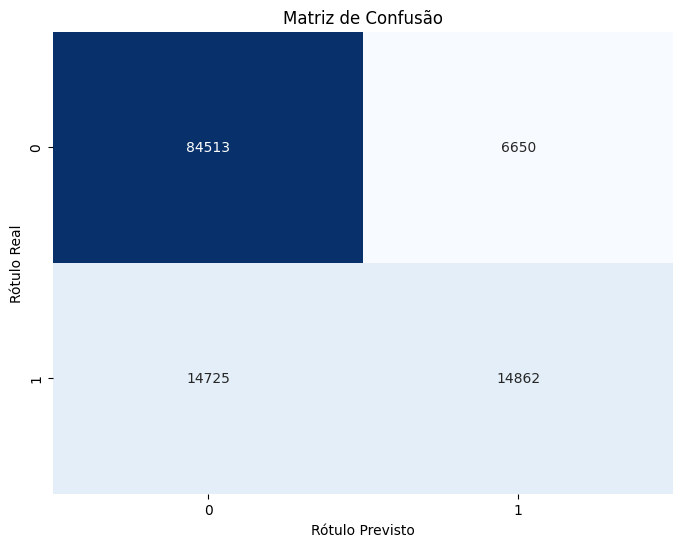

In [37]:
# Plot da matriz de confusão
matriz_confusao = confusion_matrix(y, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.show()

roc_auc 0.8658560881523677
GINI 0.7317121763047354


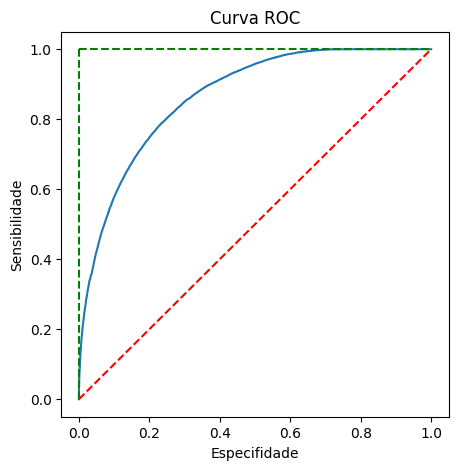

In [38]:
# Plot da curva ROC
prob_previsao = modelo.predict_proba(meta_features_train)[:,1]

tfp, tvp, limite = roc_curve(y, prob_previsao)
print('roc_auc', roc_auc_score(y, prob_previsao))
print('GINI', 2*roc_auc_score(y, prob_previsao)-1)


plt.subplots(1, figsize=(5,5))
plt.title('Curva ROC')
plt.plot(tfp,tvp)
plt.xlabel('Especifidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls="--", c = 'red') #plotando linha guia pontilhada vermelha
plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green') #plotando linha guia pontilhada verde
plt.show()

#### INDICADORES DE DF_TESTE

In [39]:
# Cálculo do indicador de acurácia do modelo
predictions = modelo.predict(meta_features_test)

accuracy = accuracy_score(y_teste, predictions)
accuracy = round(accuracy, 3)*100
print(accuracy)

71.3


In [40]:
# Cálculo dos indicadores de precision, recall e f1-score
print(classification_report(y_teste, predictions))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     39071
           1       0.39      0.29      0.33     12680

    accuracy                           0.71     51751
   macro avg       0.59      0.57      0.57     51751
weighted avg       0.69      0.71      0.70     51751



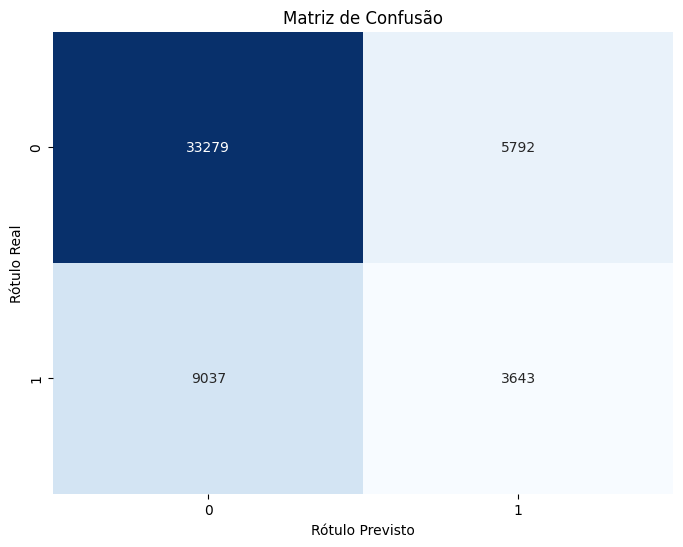

In [41]:
# Plot da matriz de confusão
matriz_confusao = confusion_matrix(y_teste, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.show()

roc_auc 0.6360276319330327
GINI 0.2720552638660654


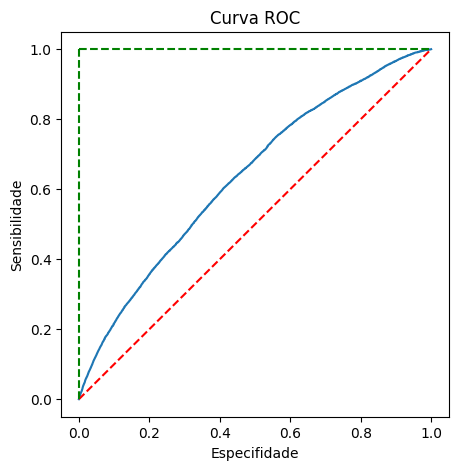

In [42]:
# Plot da curva ROC
prob_previsao = modelo.predict_proba(meta_features_test)[:,1]

tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
print('roc_auc', roc_auc_score(y_teste, prob_previsao))
print('GINI', 2*roc_auc_score(y_teste, prob_previsao)-1)


plt.subplots(1, figsize=(5,5))
plt.title('Curva ROC')
plt.plot(tfp,tvp)
plt.xlabel('Especifidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls="--", c = 'red') #plotando linha guia pontilhada vermelha
plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green') #plotando linha guia pontilhada verde
plt.show()

#### CÁLCULO DO KS

In [43]:
df_train['predicted'] = modelo.predict(meta_features_train)
df_train['probability_default'] = modelo.predict_proba(meta_features_train)[:,1]

class0 = df_train[df_train['TARGET'] == 0]
class1 = df_train[df_train['TARGET'] == 1]

ks_2samp(class0['probability_default'], class1['probability_default'])

KstestResult(statistic=np.float64(0.5541662483794669), pvalue=np.float64(0.0), statistic_location=np.float64(0.22368387727104003), statistic_sign=np.int8(1))

In [44]:
df_test['predicted'] = modelo.predict(meta_features_test)
df_test['probability_default'] = modelo.predict_proba(meta_features_test)[:,1]

class0 = df_test[df_test['TARGET'] == 0]
class1 = df_test[df_test['TARGET'] == 1]

ks_2samp(class0['probability_default'], class1['probability_default'])

KstestResult(statistic=np.float64(0.19248860987281347), pvalue=np.float64(3.7795738698704e-311), statistic_location=np.float64(0.14456831136208048), statistic_sign=np.int8(1))

## ANÁLISE FINANCEIRA

In [45]:
# Politica AS IS 
df_test['predicted-as-is'] = np.where(df_test['IDADE_ORIGINAL'] > 29, 0, 1)

In [46]:
# Pergunta 1
print(f"A financeira emprestou R${1000 * df_test[df_test['ref_date_trunc'] == '2017-08-01'].shape[0]}")

A financeira emprestou R$7305000


In [47]:
# Pergunta 2
print(f"O valor da dívida total é R${1000 * df_test[df_test['predicted-as-is'] == 1][df_test['ref_date_trunc'] == '2017-08-01'].shape[0]}")

O valor da dívida total é R$1537000


In [48]:
# Pergunta 3.1
print(f"O percentual de pessoas que teve o empréstimo negado foi: {df_test[df_test['ref_date_trunc'] == '2017-08-01']['predicted-as-is'].mean()*100 :.2f}%")

O percentual de pessoas que teve o empréstimo negado foi: 21.04%


In [49]:
# Pergunta 3.2 
print(f"Definição do threshold para a política to-be: {df_test['probability_default'].quantile(0.2104) * 100 :.2f}%")

Definição do threshold para a política to-be: 4.57%


In [50]:
# Politica TO BE
df_test['predicted-to-be'] = np.where(df_test['probability_default'] > 0.0457, 1, 0)
print(f"O valor da dívida total na política to be seria R${1000 * df_test[df_test['predicted-to-be'] == 1][df_test['ref_date_trunc'] == '2017-08-01'].shape[0]}")

O valor da dívida total na política to be seria R$5517000


## BASE OOT

In [51]:
# Preenchimento de nulos
df_oot[vars_categoricas] = df_oot[vars_categoricas].fillna(mode_values)
df_oot[vars_numericas] = df_oot[vars_numericas].fillna(median_values)

# Substituindo variáveis flag
df_oot[lst_flags] = df_oot[lst_flags].replace({'S': 1, 'N': 0})

# Label Encoding df_oot
for var in lst_label_encode:
    label_encoder.classes_ = np.append(label_encoder.classes_, 'DESCONHECIDO')
    df_oot[var] = df_oot[var].apply(lambda x: x if x in label_encoder.classes_[:-1] else 'DESCONHECIDO')
    df_oot[var] = label_encoder.transform(df_oot[var])

# One Hot Encoding df_oot
df_oot = pd.get_dummies(df_oot, columns=lst_one_hot_encoding)
df_oot = df_oot.reindex(columns=train_columns, fill_value=0)
df_oot[lst_vars_bool] = df_oot[lst_vars_bool].astype(int)

# Escalonando oot
df_oot[lst_scaler] = scaler.transform(df_oot[lst_scaler])

In [53]:
# Escorando o dataframe
df_oot['lr_balanceado_prediction'] = modelo_lr_balanceado.predict(df_oot[vars_selecionadas])
xgb_pred_oot = xgb_model.predict_proba(df_oot[[*vars_selecionadas, 'lr_balanceado_prediction']])[:, 1]
knn_pred_oot = knn_model.predict_proba(df_oot[[*vars_selecionadas, 'lr_balanceado_prediction']])[:, 1]
meta_features_oot = pd.DataFrame({
    'xgb_pred': xgb_pred_oot,
    'knn_pred': knn_pred_oot
})
df_oot['prediction'] = modelo.predict(meta_features_oot)
df_oot['probability_default'] = modelo.predict_proba(meta_features_oot)[:, 1]

# Exportação do arquivo
df_oot.to_parquet('oot_escorado.parquet.gzip', compression='gzip')